In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

Text(0.5, 1.0, 'Sensor-State Model')

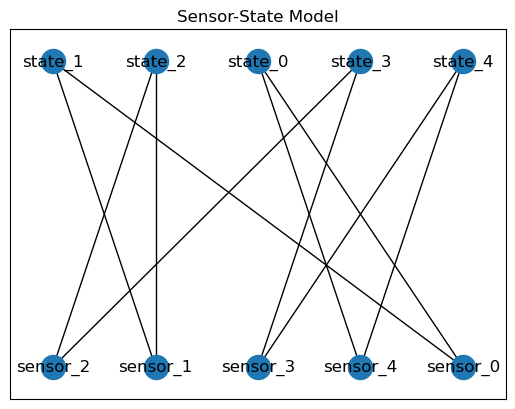

In [15]:
# Sensor-State Model
num_sensors = 5
num_states = 5
sensors = [f"sensor_{i}" for i in range(num_sensors)]
states = [f"state_{i}" for i in range(num_states)]

edge_list = [   ("sensor_0", "state_0"), 
                ("sensor_0", "state_1"),
                ("sensor_1", "state_1"),
                ("sensor_1", "state_2"),
                ("sensor_2", "state_2"),
                ("sensor_2", "state_3"),
                ("sensor_3", "state_3"),
                ("sensor_3", "state_4"),
                ("sensor_4", "state_4"),
                ("sensor_4", "state_0"),
            ]

G = nx.Graph()
for s in sensors:
    G.add_node(s, **{"type": "sensor", "attack_status": 0, "belief": 0.1})

for s in states:
    G.add_node(s, **{"type": "state", "attack_status": 0})

G.add_edges_from(edge_list)

nx.draw_networkx(G, pos=nx.drawing.layout.bipartite_layout(G, sensors, align="horizontal"))
plt.title("Sensor-State Model")

In [16]:
for node in G.nodes:
    print(G.nodes[node])

{'type': 'sensor', 'attack_status': 0, 'belief': 0.1}
{'type': 'sensor', 'attack_status': 0, 'belief': 0.1}
{'type': 'sensor', 'attack_status': 0, 'belief': 0.1}
{'type': 'sensor', 'attack_status': 0, 'belief': 0.1}
{'type': 'sensor', 'attack_status': 0, 'belief': 0.1}
{'type': 'state', 'attack_status': 0}
{'type': 'state', 'attack_status': 0}
{'type': 'state', 'attack_status': 0}
{'type': 'state', 'attack_status': 0}
{'type': 'state', 'attack_status': 0}


In [17]:
def p_state_given_sensor(graph: nx.Graph, state: str, sensor: str):
    """
    Returns P(s_{sensor} = 0 | z_{state} = 0)
    """
    rho = 1
    if not graph.has_edge(state, sensor):
        return 0
    for node in graph.neighbors(state):
        if node == sensor:
            continue
        rho *= (1-graph.nodes[node]['belief'])

    return rho

def compute_alpha(graph: nx.Graph, state: str, sensor: str, sensor_attack_status: int, xi: float, eta: float):
    rho = p_state_given_sensor(graph, state, sensor)
    q = 1 - rho
    return  (1-xi)*(q**(1-sensor_attack_status)) + (1-sensor_attack_status)*eta*rho

def compute_beta(graph: nx.Graph, state: str, sensor: str, sensor_attack_status: int, xi: float, eta: float):
    rho = p_state_given_sensor(graph, state, sensor)
    q = 1 - rho
    return xi*(q**(1-sensor_attack_status)) + (1-sensor_attack_status)*(1-eta)*rho

def p_alerts_given_sensor(graph: nx.Graph, alerts: dict, sensor: str, sensor_attack_status: int, xi: float, eta: float):
    """
    Computes P(A_t | z_{sensor} = sensor_attack_status)

    params:
        graph:  sensor-state graph
        alerts: alerts from system
        ...
        xi:     probability of missed detection
        eta:    probability of false alarm
    """
    p = 1
    for node in graph.neighbors(sensor):
        if alerts[node]:
            p *= compute_alpha(graph, node, sensor, sensor_attack_status, xi, eta)
        else:
            p *= compute_beta(graph, node, sensor, sensor_attack_status, xi, eta)

    return p

def posterior_update(graph: nx.Graph, alerts: dict, xi: float, eta: float, eps=1e-6):
    prior = {node: graph.nodes[node]['belief'] for node in filter(lambda x: graph.nodes[x]['type'] == "sensor", graph.nodes)}
    posterior = {}

    for node in filter(lambda x: graph.nodes[x]['type'] == "sensor", graph.nodes):
        evidence = p_alerts_given_sensor(graph, alerts, node, sensor_attack_status=1, xi=xi, eta=eta)
        normalizing_factor =    p_alerts_given_sensor(graph, alerts, node, sensor_attack_status=1, xi=xi, eta=eta)*prior[node] + \
                                p_alerts_given_sensor(graph, alerts, node, sensor_attack_status=0, xi=xi, eta=eta)*(1-prior[node])
        
        posterior[node] = min(max(evidence*prior[node] / normalizing_factor, eps), 1-eps)
        graph.nodes[node]['belief'] = posterior[node]
    
    return graph, posterior

def reset_beliefs(graph: nx.Graph):
    for node in graph.nodes:
        graph.nodes[node]['belief'] = 0.1

In [6]:
# Simulation
reset_beliefs(G)
print("Beliefs have been reset to: " + str([G.nodes[node]['belief'] for node in G.nodes if G.nodes[node]["type"] == "sensor"]))
num_steps = 200
attack_start_time = 50
attack_end_time = 100
attacked_sensors = ["sensor_0", "sensor_1"]
attacked_states = set()
for sensor in attacked_sensors:
    attacked_states = attacked_states.union(set(G.neighbors(sensor)))
xi = 0.05
eta = 0.05


belief = {f"sensor_{i}": [0.1] for i in range(num_sensors)}
naive_diagnosis = {f"sensor_{i}": [0] for i in range(num_sensors)}

for t in range(num_steps):
    
    alerts = {f"state_{i}": 1 if np.random.rand() < eta else 0 for i in range(num_states)}
    # Retrieves all sensors which has at least one state alert in a set
    if t > attack_start_time and t < attack_end_time:
        for state in attacked_states:
            alerts[state] = 1 if np.random.rand() > xi else 0

    if t > attack_end_time:
        pass

    alerted_sensors = set().union(*[set(G.neighbors(state)) for state in alerts.keys() if alerts[state] == 1] )
    for sensor in naive_diagnosis.keys():
        naive_diagnosis[sensor].append(1) if sensor in alerted_sensors else naive_diagnosis[sensor].append(0)
        
    G, pos = posterior_update(graph=G, alerts=alerts, xi=xi, eta=eta)
    for i in range(num_sensors):
        belief[f"sensor_{i}"].append(pos[f"sensor_{i}"])

Beliefs have been reset to: [0.1, 0.1, 0.1, 0.1, 0.1]


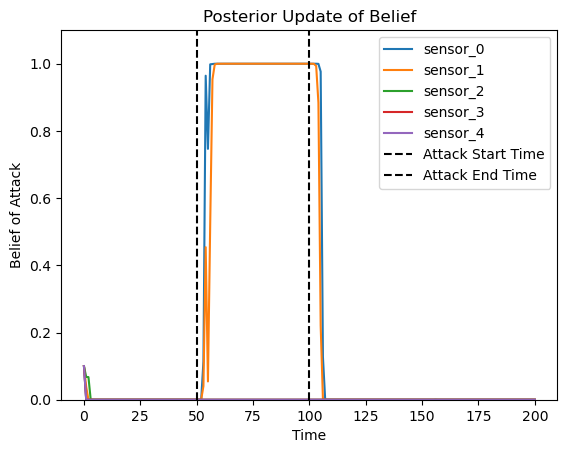

In [7]:
for i in range(num_sensors):
    plt.plot(range(num_steps+1), belief[f"sensor_{i}"], label=f"sensor_{i}")
plt.vlines(x=attack_start_time, ymin=0, ymax=1.1, color="black", linestyle="dashed", label="Attack Start Time")
plt.vlines(x=attack_end_time, ymin=0, ymax=1.1, color="black", linestyle="dashed", label="Attack End Time")
plt.ylim(bottom=0, top=1.1)
plt.title("Posterior Update of Belief")
plt.xlabel("Time")
plt.ylabel("Belief of Attack")
plt.legend()
plt.show()

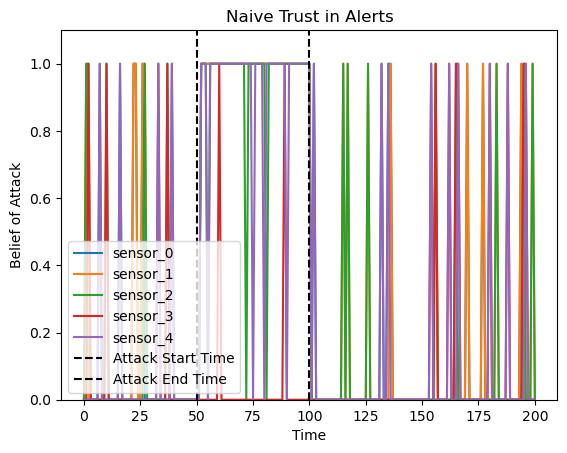

In [8]:
for i in range(num_sensors):
    plt.plot(range(num_steps+1), naive_diagnosis[f"sensor_{i}"], label=f"sensor_{i}")
plt.vlines(x=attack_start_time, ymin=0, ymax=1.1, color="black", linestyle="dashed", label="Attack Start Time")
plt.vlines(x=attack_end_time, ymin=0, ymax=1.1, color="black", linestyle="dashed", label="Attack End Time")
plt.ylim(bottom=0, top=1.1)
plt.title("Naive Trust in Alerts")
plt.xlabel("Time")
plt.ylabel("Belief of Attack")
plt.legend()
plt.show()

In [9]:
import random

def run_sim(G: nx.Graph, num_steps: int = 200):
    reset_beliefs(G)
    attack_start_time = random.randint(0, num_steps // 2)
    attack_end_time = num_steps
    # attacked_sensors = np.random.choice(list(G.nodes), size=random.randint(1,2), replace=False, p=[1/num_sensors if G.nodes[node]['type'] == 'sensor' else 0 for node in G.nodes])
    attacked_sensors = ["sensor_0", "sensor_1"]
    attacked_states = set()
    for sensor in attacked_sensors:
        attacked_states = attacked_states.union(set(G.neighbors(sensor)))
    xi = 0.05
    eta = 0.05

    belief = {f"sensor_{i}": [0.1] for i in range(num_sensors)}
    naive_diagnosis = {f"sensor_{i}": [0] for i in range(num_sensors)}

    for t in range(num_steps):
        
        alerts = {f"state_{i}": 1 if np.random.rand() < eta else 0 for i in range(num_states)}
        # Retrieves all sensors which has at least one state alert in a set
        if t > attack_start_time and t < attack_end_time:
            for state in attacked_states:
                alerts[state] = 1 if np.random.rand() > xi else 0

        if t > attack_end_time:
            pass
        
        alerted_sensors = set().union(*[set(G.neighbors(state)) for state in alerts.keys() if alerts[state] == 1] )
        for sensor in naive_diagnosis.keys():
            naive_diagnosis[sensor].append(1) if sensor in alerted_sensors else naive_diagnosis[sensor].append(0)

        G, pos = posterior_update(graph=G, alerts=alerts, xi=xi, eta=eta)
        for i in range(num_sensors):
            belief[f"sensor_{i}"].append(pos[f"sensor_{i}"])

    return belief, naive_diagnosis, attacked_sensors, attack_start_time

In [128]:
# Run simulation 10 times and store results in a pandas dataframe with index simulation_id
import pandas as pd
simulation_results = pd.DataFrame()
num_steps = 200
for i in range(1000):
    belief, naive_diagnosis, attacked_sensors, attack_start_time = run_sim(G, num_steps=num_steps)
    data = belief
    data["time"] = list(range(num_steps+1))
    for j in range(num_sensors):
        data[f"attack_status_sensor_{j}"] = (attack_start_time+1)*[0] + (num_steps-attack_start_time)*[1] if f"sensor_{j}" in attacked_sensors else (num_steps+1)*[0]
        data[f"naive_diagnosis_sensor_{j}"] = naive_diagnosis[f"sensor_{j}"]

    tmp_df = pd.DataFrame(data)
    tmp_df['simulation_id'] = [i] * (num_steps + 1)
    simulation_results = pd.concat([simulation_results, tmp_df])

In [129]:
latency_df = pd.DataFrame()
latency_df['simulation_id'] = range(1000)

for i in range(num_sensors):
    tmp = simulation_results.copy()

    for j in range(num_sensors):
        tmp[f"prediction_{j}"] = (tmp[f"sensor_{j}"] >= 0.5)

    event_start = (
        tmp[tmp[f"attack_status_sensor_{i}"] == 1]
        .groupby("simulation_id")["time"]
        .min()
        .rename(f"event_start_{i}")
    )

    valid_pred = (
        tmp.merge(event_start, left_on='simulation_id', right_index=True)
        .query(f'prediction_{i} == 1 and time >= event_start_{i}')
    )

    detection_times = (
        valid_pred
        .groupby("simulation_id")["time"]
        .min()
        .rename(f"detect_time_{i}")
    )

    valid_pred_n = (
        tmp.merge(event_start, left_on='simulation_id', right_index=True)
        .query(f'naive_diagnosis_sensor_{i} == 1 and time >= event_start_{i}')
    )

    detection_times_naive = (
        valid_pred_n
        .groupby("simulation_id")['time']
        .min()
        .rename(f"naive_detect_time_{i}")
    )

    latency_df_tmp = (
        pd.concat([event_start, detection_times, detection_times_naive], axis=1)
        .dropna(subset=[f'event_start_{i}', f'detect_time_{i}', f'naive_detect_time_{i}'])           # keep only detected cases
        # .assign(latency=lambda x: x[f'detect_time_{i}'] - x[f'event_start_{i}'])
        # .assign(naive_latency=lambda x: x[f'naive_detect_time_{i}'] - x[f'event_start_{i}'])
    )

    latency_df_tmp[f'latency_{i}'] = latency_df_tmp[f'detect_time_{i}'] - latency_df_tmp[f'event_start_{i}']
    latency_df_tmp[f"naive_latency_{i}"] = latency_df_tmp[f'naive_detect_time_{i}'] - latency_df_tmp[f'event_start_{i}']
    latency_df = latency_df.merge(latency_df_tmp, how="outer", on="simulation_id")

latency_df

,simulation_id,event_start_0,detect_time_0,naive_detect_time_0,latency_0,naive_latency_0,event_start_1,detect_time_1,naive_detect_time_1,latency_1,...,event_start_3,detect_time_3,naive_detect_time_3,latency_3,naive_latency_3,event_start_4,detect_time_4,naive_detect_time_4,latency_4,naive_latency_4
0,0,62,65,63,3,1,62,66,63,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,40,43,41,3,1,40,44,41,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,12,15,13,3,1,12,16,13,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,16,21,17,5,1,16,19,17,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,87,90,88,3,1,87,91,88,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,54,57,54,3,0,54,58,55,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,996,86,89,87,3,1,86,90,87,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,997,33,36,34,3,1,33,39,34,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,998,47,51,48,4,1,47,52,47,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
for i in range(num_sensors):
    print(f"Mean Detection Latency Sensor {i} (Ours): ", latency_df[f"latency_{i}"].mean(skipna=True))
    print(f"Mean Detection Latency Sensor {i} (Naive): ", latency_df[f"naive_latency_{i}"].mean(skipna=True))

Mean Detection Latency Sensor 0 (Ours):  3.477
Mean Detection Latency Sensor 0 (Naive):  0.9
Mean Detection Latency Sensor 1 (Ours):  4.533
Mean Detection Latency Sensor 1 (Naive):  0.906
Mean Detection Latency Sensor 2 (Ours):  nan
Mean Detection Latency Sensor 2 (Naive):  nan
Mean Detection Latency Sensor 3 (Ours):  nan
Mean Detection Latency Sensor 3 (Naive):  nan
Mean Detection Latency Sensor 4 (Ours):  nan
Mean Detection Latency Sensor 4 (Naive):  nan


In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

metrics_df = simulation_results.copy()
metrics_df["pred_1"] = metrics_df["sensor_1"] >= 0.5

acc = (metrics_df["pred_1"] == metrics_df["attack_status_sensor_1"]).mean()
n_acc = (metrics_df["naive_diagnosis_sensor_1"] == metrics_df["attack_status_sensor_1"]).mean()

fpr = len(metrics_df[(metrics_df["pred_1"] == 1) & (metrics_df["attack_status_sensor_1"] == 0)]) / len(metrics_df)
n_fpr = len(metrics_df[(metrics_df["naive_diagnosis_sensor_1"] == 1) & (metrics_df["attack_status_sensor_1"] == 0)]) / len(metrics_df)

fnr = len(metrics_df[(metrics_df["pred_1"] == 0) & (metrics_df["attack_status_sensor_1"] == 1)]) / len(metrics_df)
n_fnr = len(metrics_df[(metrics_df["naive_diagnosis_sensor_1"] == 0) & (metrics_df["attack_status_sensor_1"] == 1)]) / len(metrics_df)

prec = precision_score(metrics_df["attack_status_sensor_1"], metrics_df["pred_1"])
n_prec = precision_score(metrics_df["attack_status_sensor_1"], metrics_df["naive_diagnosis_sensor_1"])
rec = recall_score(metrics_df["attack_status_sensor_1"], metrics_df["pred_1"])
n_rec = recall_score(metrics_df["attack_status_sensor_1"], metrics_df["naive_diagnosis_sensor_1"])

print("Accuracy (Ours): ", acc)
print("Accuracy (Naive): ", n_acc)

print("Precision (Ours): ", prec)
print("Precision (Naive): ", n_prec)

print("Recall (Ours): ", rec)
print("Recall (Naive): ", n_rec)



print("FPR (Ours): ", fpr)
print("FPR (Naive): ", n_fpr)

print("FNR (Ours): ", fnr)
print("FNR (Naive): ", n_fnr)

Accuracy (Ours):  0.9771442786069652
Accuracy (Naive):  0.9697860696517413
Precision (Ours):  0.999965629124505
Precision (Naive):  0.96860008722198
Recall (Ours):  0.9694180839153382
Recall (Naive):  0.9916764407954364
FPR (Ours):  2.4875621890547263e-05
FPR (Naive):  0.024
FNR (Ours):  0.02283084577114428
FNR (Naive):  0.006213930348258706


In [18]:
# Calculate and display the accuracy of the naive diagnosis and the posterior beliefs with threshold 0.5
# Calculate and display the mean detection latency for each sensor
# Calculate and display the mean false positive rate for each sensor

import numpy as np
def calculate_metrics(simulation_results: pd.DataFrame, num_sensors: int):
    metrics = {}
    for sensor in range(num_sensors):
        sensor_col = f"sensor_{sensor}"
        attack_col = f"attack_status_sensor_{sensor}"
        naive_col = f"naive_diagnosis_sensor_{sensor}"
        
        # Calculate accuracy
        correct_diagnosis = (simulation_results[sensor_col] >= 0.5) == simulation_results[attack_col]
        accuracy = correct_diagnosis.mean()
        
        # Calculate detection latency: group by simulation_id and find the first time step where the sensor detects an attack 
        # if false positive, then the first time step where it detects an attack
        detection_latency = simulation_results[correct_diagnosis].groupby('simulation_id').first().reset_index()
        detection_latency = detection_latency.groupby('simulation_id')[sensor_col].apply(lambda x: (x >= 0.5).idxmax() if not x.empty else np.nan)
        detection_latency = detection_latency.mean() if not detection_latency.empty else np.nan
        detection_latency = detection_latency - simulation_results[attack_col].groupby('simulation_id').first().reset_index()['time'].mean()
        
        # Calculate false positive rate
        false_positives = ((simulation_results[sensor_col] >= 0.5) & (simulation_results[attack_col] == 0)).sum()
        total_negatives = (simulation_results[attack_col] == 0).sum()
        false_positive_rate = false_positives / total_negatives if total_negatives > 0 else np.nan
        
        metrics[sensor] = {
            'accuracy': accuracy,
            'detection_latency': detection_latency,
            'false_positive_rate': false_positive_rate
        }
    
    return pd.DataFrame(metrics).T

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,time,attack_status_sensor_0,naive_diagnosis_sensor_0,attack_status_sensor_1,naive_diagnosis_sensor_1,attack_status_sensor_2,naive_diagnosis_sensor_2,attack_status_sensor_3,naive_diagnosis_sensor_3,attack_status_sensor_4,naive_diagnosis_sensor_4,simulation_id
0,0.100000,0.100000,0.100000,0.100000,0.100000,0,0,0,0,0,0,0,0,0,0,0,0
1,0.000375,0.000340,0.000340,0.000340,0.000308,1,0,0,0,0,0,0,0,0,0,0,0
2,0.000001,0.000001,0.000001,0.000001,0.000001,2,0,0,0,0,0,0,0,0,0,0,0
3,0.000001,0.000001,0.000001,0.000001,0.000001,3,0,0,0,0,0,0,0,0,0,0,0
4,0.000001,0.000001,0.000001,0.000001,0.000001,4,0,0,0,0,0,0,0,0,0,0,0


In [165]:
data = belief
data["time"] = list(range(num_steps+1))
for i in range(num_sensors):
    data[f"attack_status_sensor_{i}"] = (attack_start_time+1)*[0] + (num_steps-attack_start_time)*[1] if f"sensor_{i}" in attacked_sensors else (num_steps+1)*[0]
    data[f"naive_diagnosis_sensor_{i}"] = naive_diagnosis[f"sensor_{i}"]
df = pd.DataFrame(data=data)
df.head()

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,time,attack_status_sensor_0,attack_status_sensor_1,attack_status_sensor_2,attack_status_sensor_3,attack_status_sensor_4
0,0.100000,0.10000,0.10000,0.10000,0.100000,0,0,0,0,0,0
1,0.000375,0.00034,0.00034,0.00034,0.000308,1,0,0,0,0,0
2,0.000010,0.00001,0.00001,0.00001,0.000010,2,0,0,0,0,0
3,0.000010,0.00001,0.00001,0.00001,0.000010,3,0,0,0,0,0
4,0.000010,0.00001,0.00001,0.00001,0.000010,4,0,0,0,0,0


In [166]:
df[df.attack_status_sensor_3 == 1]

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,time,attack_status_sensor_0,attack_status_sensor_1,attack_status_sensor_2,attack_status_sensor_3,attack_status_sensor_4
51,0.00001,0.00001,0.000010,0.000010,0.00001,51,0,0,1,1,0
52,0.00001,0.00001,0.003596,0.003379,0.00001,52,0,0,1,1,0
53,0.00001,0.00001,0.551137,0.100754,0.00001,53,0,0,1,1,0
54,0.00001,0.00001,0.993691,0.681653,0.00001,54,0,0,1,1,0
55,0.00001,0.00001,0.922301,0.977732,0.00001,55,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
196,0.00001,0.00001,1.000000,1.000000,0.00001,196,0,0,1,1,0
197,0.00001,0.00001,1.000000,1.000000,0.00001,197,0,0,1,1,0
198,0.00001,0.00001,1.000000,1.000000,0.00001,198,0,0,1,1,0
199,0.00001,0.00001,1.000000,1.000000,0.00001,199,0,0,1,1,0


### With Querying

In [18]:
from scipy.stats import norm

def metropolis_hastings_sampler(p, N, theta0, epsilon):
  chain = np.zeros((2,N))
  theta = theta0
  for i in range(N):
    y = np.random.normal(loc=theta, scale=epsilon)
    alpha = p(y) / p(theta)

    if np.random.rand() <= alpha:
      chain[:,i] = y
      theta = y
    else:
      chain[:,i] = theta

  return chain

def p_state_residual_given_sensor(graph: nx.Graph, residuals: dict, state: str, sensor: str, sensor_attack_status: int, distr_var: float=1.0):
  """
  Computes P(residual_{state} | z_{sensor} = sensor_attack_status)

  params:
    ...

  """
  
  rho = p_state_given_sensor(graph, state, sensor)
  residual = residuals[state]
  benign_distribution = norm(loc=0, scale=distr_var)
  malicious_distribution = norm(loc=residual, scale=distr_var)

  return ((1-rho)**(1-sensor_attack_status)) * malicious_distribution.pdf(residual) + (1-sensor_attack_status)*rho*benign_distribution.pdf(residual) 

def p_residuals_given_sensor(graph: nx.Graph, residuals: dict, sensor: str, sensor_attack_status: int, distr_var: float=1.0):
  """
  Computes P(residuals | z_{sensor} = sensor_attack_status)

  params:
    ...

  """
  p = 1

  for node in graph.neighbors(sensor):
    p *= p_state_residual_given_sensor(graph, residuals, node, sensor, sensor_attack_status, distr_var)

  return p


def query_posterior_update(graph: nx.Graph, residuals: dict, sensor: str, distr_var: float = 1.0, eps: float=1e-6):
  prior = {node: graph.nodes[node]['belief'] for node in filter(lambda x: graph.nodes[x]['type'] == "sensor", graph.nodes)}
  posterior = {}

  evidence = p_residuals_given_sensor(graph, residuals, sensor, sensor_attack_status=0, distr_var=distr_var)
  normalizing_factor =  p_residuals_given_sensor(graph, residuals, sensor, sensor_attack_status=0, distr_var=distr_var)*(1-prior[sensor]) + \
                        p_residuals_given_sensor(graph, residuals, sensor, sensor_attack_status=1, distr_var=distr_var)*prior[sensor]
  
  posterior[sensor] = 1 - min(max(evidence*(1-prior[sensor]) / normalizing_factor, eps), 1-eps)
  graph.nodes[sensor]['belief'] = posterior[sensor]

  return graph, posterior

In [20]:
# Simulation (with Querying)
reset_beliefs(G)
print("Beliefs have been reset to: " + str([G.nodes[node]['belief'] for node in G.nodes if G.nodes[node]["type"] == "sensor"]))
num_steps = 200
attack_start_time = 50
attack_end_time = 100
attacked_sensors = ["sensor_0", "sensor_1"]
attacked_states = set()
for sensor in attacked_sensors:
    attacked_states = attacked_states.union(set(G.neighbors(sensor)))
xi = 0.05
eta = 0.05

query_lower_bound = 0.0
query_upper_bound = 1.0

belief = {f"sensor_{i}": [0.1] for i in range(num_sensors)}
naive_diagnosis = {f"sensor_{i}": [0] for i in range(num_sensors)}

query_decision = False

for t in range(num_steps):
    
    alerts = {f"state_{i}": 1 if np.random.rand() < eta else 0 for i in range(num_states)}
    residuals = {f"state_{i}": np.random.normal(loc=0, scale=1.0) for i in range(num_states)}
    # Retrieves all sensors which has at least one state alert in a set
    if t > attack_start_time and t < attack_end_time:
        for state in attacked_states:
            alerts[state] = 1 if np.random.rand() > xi else 0
            mu = 0.8 + 4*np.random.rand()
            residuals[state] = np.random.normal(loc=mu, scale=1.0)

    if t > attack_end_time:
        pass

    alerted_sensors = set().union(*[set(G.neighbors(state)) for state in alerts.keys() if alerts[state] == 1] )
    for sensor in naive_diagnosis.keys():
        naive_diagnosis[sensor].append(1) if sensor in alerted_sensors else naive_diagnosis[sensor].append(0)
        
    G, pos = posterior_update(graph=G, alerts=alerts, xi=xi, eta=eta)

    posterior = pos
    for i in range(num_sensors):
        if query_lower_bound < G.nodes[f"sensor_{i}"]["belief"] < query_upper_bound:
            G, pos = query_posterior_update(graph=G, residuals=residuals, sensor=f"sensor_{i}")
            posterior[f"sensor_{i}"] = pos[f"sensor_{i}"]
    for i in range(num_sensors):
        belief[f"sensor_{i}"].append(posterior[f"sensor_{i}"])
        

Beliefs have been reset to: [0.1, 0.1, 0.1, 0.1, 0.1]


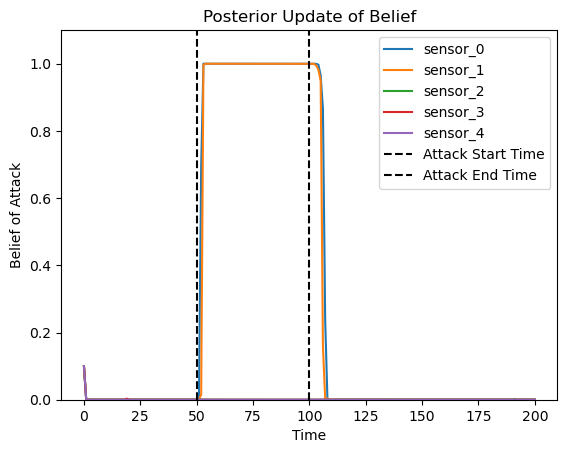

In [21]:
for i in range(num_sensors):
    plt.plot(range(num_steps+1), belief[f"sensor_{i}"], label=f"sensor_{i}")
plt.vlines(x=attack_start_time, ymin=0, ymax=1.1, color="black", linestyle="dashed", label="Attack Start Time")
plt.vlines(x=attack_end_time, ymin=0, ymax=1.1, color="black", linestyle="dashed", label="Attack End Time")
plt.ylim(bottom=0, top=1.1)
plt.title("Posterior Update of Belief")
plt.xlabel("Time")
plt.ylabel("Belief of Attack")
plt.legend()
plt.show()

In [24]:
import random

def run_sim_with_queries(G: nx.Graph, num_steps: int = 200):
    reset_beliefs(G)
    G_q = G.copy()
    attack_start_time = random.randint(0, num_steps // 2)
    attack_end_time = num_steps
    attacked_sensors = ["sensor_0", "sensor_1"]
    attacked_states = set()
    for sensor in attacked_sensors:
        attacked_states = attacked_states.union(set(G.neighbors(sensor)))
    xi = 0.05
    eta = 0.05

    belief = {f"sensor_{i}": [0.1] for i in range(num_sensors)}
    belief_q = {f"sensor_{i}": [0.1] for i in range(num_sensors)}
    naive_diagnosis = {f"sensor_{i}": [0] for i in range(num_sensors)}

    for t in range(num_steps):
        
        alerts = {f"state_{i}": 1 if np.random.rand() < eta else 0 for i in range(num_states)}
        residuals = {f"state_{i}": np.random.normal(loc=0, scale=1.0) for i in range(num_states)}
        # Retrieves all sensors which has at least one state alert in a set
        if t > attack_start_time and t < attack_end_time:
            for state in attacked_states:
                alerts[state] = 1 if np.random.rand() > xi else 0
                mu = 0.8 + 4*np.random.rand()
                residuals[state] = np.random.normal(loc=mu, scale=1.0)
        
        alerted_sensors = set().union(*[set(G.neighbors(state)) for state in alerts.keys() if alerts[state] == 1] )
        for sensor in naive_diagnosis.keys():
            naive_diagnosis[sensor].append(1) if sensor in alerted_sensors else naive_diagnosis[sensor].append(0)

        G, pos = posterior_update(graph=G, alerts=alerts, xi=xi, eta=eta)
        G_q, pos_q = posterior_update(graph=G_q, alerts=alerts, xi=xi, eta=eta)
        posterior = {}
        for i in range(num_sensors):
            if query_lower_bound < G_q.nodes[f"sensor_{i}"]["belief"] < query_upper_bound:
                G_q, pos_q = query_posterior_update(graph=G_q, residuals=residuals, sensor=f"sensor_{i}")
                posterior[f"sensor_{i}"] = pos_q[f"sensor_{i}"]
        
        for i in range(num_sensors):
            belief[f"sensor_{i}"].append(pos[f"sensor_{i}"])
            belief_q[f"sensor_{i}"].append(posterior[f"sensor_{i}"])

    return belief, belief_q, naive_diagnosis, attacked_sensors, attack_start_time

In [26]:
# Run simulation 10 times and store results in a pandas dataframe with index simulation_id
import pandas as pd
simulation_results = pd.DataFrame()
num_simulations = 10
num_steps = 200
for i in range(num_simulations):
    belief, belief_q, naive_diagnosis, attacked_sensors, attack_start_time = run_sim_with_queries(G, num_steps=num_steps)
    data = belief
    data["time"] = list(range(num_steps+1))
    for j in range(num_sensors):
        data[f"attack_status_sensor_{j}"] = (attack_start_time+1)*[0] + (num_steps-attack_start_time)*[1] if f"sensor_{j}" in attacked_sensors else (num_steps+1)*[0]
        data[f"naive_diagnosis_sensor_{j}"] = naive_diagnosis[f"sensor_{j}"]
        data[f"sensor_{j}_q"] = belief_q[f"sensor_{j}"]
        
    tmp_df = pd.DataFrame(data)
    tmp_df['simulation_id'] = [i] * (num_steps + 1)
    simulation_results = pd.concat([simulation_results, tmp_df])

In [29]:
latency_df = pd.DataFrame()
latency_df['simulation_id'] = range(num_simulations)

for i in range(num_sensors):
    tmp = simulation_results.copy()

    for j in range(num_sensors):
        tmp[f"prediction_{j}"] = (tmp[f"sensor_{j}"] >= 0.9)
        tmp[f"q_prediction_{j}"] = (tmp[f"sensor_{j}_q"] >= 0.9)

    event_start = (
        tmp[tmp[f"attack_status_sensor_{i}"] == 1]
        .groupby("simulation_id")["time"]
        .min()
        .rename(f"event_start_{i}")
    )

    valid_pred = (
        tmp.merge(event_start, left_on='simulation_id', right_index=True)
        .query(f'prediction_{i} == 1 and time >= event_start_{i}')
    )

    valid_pred_q = (
        tmp.merge(event_start, left_on='simulation_id', right_index=True)
        .query(f"q_prediction_{i} == 1 and time >= event_start_{i}")
    )

    valid_pred_n = (
        tmp.merge(event_start, left_on='simulation_id', right_index=True)
        .query(f'naive_diagnosis_sensor_{i} == 1 and time >= event_start_{i}')
    )

    detection_times = (
        valid_pred
        .groupby("simulation_id")["time"]
        .min()
        .rename(f"detect_time_{i}")
    )

    detection_times_q = (
        valid_pred_q
        .groupby("simulation_id")["time"]
        .min()
        .rename(f"query_detect_time_{i}")
    )

    detection_times_naive = (
        valid_pred_n
        .groupby("simulation_id")['time']
        .min()
        .rename(f"naive_detect_time_{i}")
    )

    latency_df_tmp = (
        pd.concat([event_start, detection_times, detection_times_naive, detection_times_q], axis=1)
        .dropna(subset=[f'event_start_{i}', f'detect_time_{i}', f'naive_detect_time_{i}', f'query_detect_time_{i}'])           # keep only detected cases
    )

    latency_df_tmp[f'latency_{i}'] = latency_df_tmp[f'detect_time_{i}'] - latency_df_tmp[f'event_start_{i}']
    latency_df_tmp[f'query_latency_{i}'] = latency_df_tmp[f'query_detect_time_{i}'] - latency_df_tmp[f'event_start_{i}']
    latency_df_tmp[f"naive_latency_{i}"] = latency_df_tmp[f'naive_detect_time_{i}'] - latency_df_tmp[f'event_start_{i}']
    latency_df = latency_df.merge(latency_df_tmp, how="outer", on="simulation_id")

latency_df

,simulation_id,event_start_0,detect_time_0,naive_detect_time_0,query_detect_time_0,latency_0,query_latency_0,naive_latency_0,event_start_1,detect_time_1,...,latency_3,query_latency_3,naive_latency_3,event_start_4,detect_time_4,naive_detect_time_4,query_detect_time_4,latency_4,query_latency_4,naive_latency_4
0,0,63,66,64,65,3,2,1,63,67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,48,51,49,49,3,1,1,48,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,39,42,39,40,3,1,0,39,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,90,95,91,91,5,1,1,90,94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,89,92,90,91,3,2,1,89,93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,34,37,35,36,3,2,1,34,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,36,41,36,38,5,2,0,36,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,15,18,16,16,3,1,1,15,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,92,96,93,93,4,1,1,92,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,35,38,36,36,3,1,1,35,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
print("Mean Detection Latency Sensor 0 (No Querying)", latency_df['latency_0'].mean())
print("Mean Detection Latency Sensor 0 (Querying)", latency_df['query_latency_0'].mean())
print("Mean Detection Latency Sensor 0 (Naive)", latency_df['naive_latency_0'].mean())

Mean Detection Latency Sensor 0 (No Querying) 3.5
Mean Detection Latency Sensor 0 (Querying) 1.4
Mean Detection Latency Sensor 0 (Naive) 0.8


In [35]:
simulation_results.columns

Index(['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'time',
       'attack_status_sensor_0', 'naive_diagnosis_sensor_0', 'sensor_0_q',
       'attack_status_sensor_1', 'naive_diagnosis_sensor_1', 'sensor_1_q',
       'attack_status_sensor_2', 'naive_diagnosis_sensor_2', 'sensor_2_q',
       'attack_status_sensor_3', 'naive_diagnosis_sensor_3', 'sensor_3_q',
       'attack_status_sensor_4', 'naive_diagnosis_sensor_4', 'sensor_4_q',
       'simulation_id'],
      dtype='object')

In [78]:
from functools import partial

metrics_df = simulation_results.copy()
metrics_df.rename({col: f"sensor_q_{col[7:8]}" for col in filter(lambda x: x.endswith("_q"), metrics_df.columns)}, inplace=True, axis=1)
# print(metrics_df.columns)

for i in range(num_sensors):
    metrics_df[f"pred_no_{i}"] = (metrics_df[f"sensor_{i}"] >= 0.9).map(lambda x: int(x))
    metrics_df[f"pred_q_{i}"] = (metrics_df[f"sensor_q_{i}"] >= 0.9).map(lambda x: int(x))

def create_label(row, col_prefix):
    label = ""
    for i in range(num_sensors):
        label += str(int(row[col_prefix + str(i)]))
    return label

metrics_df["pred_noq"] = metrics_df.apply(partial(create_label, col_prefix="pred_no_"), axis=1)
metrics_df["pred_query"] = metrics_df.apply(partial(create_label, col_prefix="pred_q_"), axis=1)
metrics_df['pred_naive'] = metrics_df.apply(partial(create_label, col_prefix="naive_diagnosis_sensor_"), axis=1)
metrics_df["label"] = metrics_df.apply(partial(create_label, col_prefix="attack_status_sensor_"), axis=1)

metrics_df[["pred_noq", "pred_query", "pred_naive", "label"]].tail()

,pred_noq,pred_query,pred_naive,label
196,11000,11000,11101,11000
197,11000,11000,11101,11000
198,11000,11000,11101,11000
199,11000,11000,11101,11000
200,11000,11000,11101,11000


In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from itertools import product

labels = list(map(lambda x: "".join(x), product(["0", "1"], repeat=5)))

acc_noq = accuracy_score(metrics_df['label'], metrics_df['pred_noq'])
acc_q = accuracy_score(metrics_df['label'], metrics_df['pred_query'])
acc_n = accuracy_score(metrics_df['label'], metrics_df['pred_naive'])

pre_noq = precision_score(metrics_df['label'], metrics_df['pred_noq'], labels=labels, average="micro")
pre_q = precision_score(metrics_df['label'], metrics_df['pred_query'], labels=labels, average="micro")
pre_n = precision_score(metrics_df['label'], metrics_df['pred_naive'], labels=labels, average="micro")

rec_noq = recall_score(metrics_df['label'], metrics_df['pred_noq'], labels=labels, average="micro")
rec_q = recall_score(metrics_df['label'], metrics_df['pred_query'], labels=labels, average="micro")
rec_n = recall_score(metrics_df['label'], metrics_df['pred_naive'], labels=labels, average="micro")

print("Accuracy (with Query): ", round(acc_q, 4))
print("Accuracy (no Query): ", round(acc_noq, 4))
print("Accuracy (Naive): ", round(acc_n, 4))

print("Precision (with Query): ", round(pre_q, 4))
print("Precision (no Query): ", round(pre_noq, 4))
print("Precision (Naive): ", round(pre_n, 4))

print("Recall (with Query): ", round(rec_q, 4))
print("Recall (no Query): ", round(rec_noq, 4))
print("Recall (Naive): ", round(rec_n, 4))


Accuracy (with Query):  0.9881
Accuracy (no Query):  0.9781
Accuracy (Naive):  0.2109
Precision (with Query):  0.9881
Precision (no Query):  0.9781
Precision (Naive):  0.2109
Recall (with Query):  0.9881
Recall (no Query):  0.9781
Recall (Naive):  0.2109


In [77]:
simulation_results.dtypes

sensor_0                    float64
sensor_1                    float64
sensor_2                    float64
sensor_3                    float64
sensor_4                    float64
time                          int64
attack_status_sensor_0        int64
naive_diagnosis_sensor_0      int64
sensor_0_q                  float64
attack_status_sensor_1        int64
naive_diagnosis_sensor_1      int64
sensor_1_q                  float64
attack_status_sensor_2        int64
naive_diagnosis_sensor_2      int64
sensor_2_q                  float64
attack_status_sensor_3        int64
naive_diagnosis_sensor_3      int64
sensor_3_q                  float64
attack_status_sensor_4        int64
naive_diagnosis_sensor_4      int64
sensor_4_q                  float64
simulation_id                 int64
dtype: object

In [75]:
acc_noq

0.9781094527363184

In [76]:
acc_q

0.9880597014925373